In [ ]:
from google.colab import drive

In [ ]:

drive.mount("/content/colab/")

Drive already mounted at /content/colab/; to attempt to forcibly remount, call drive.mount("/content/colab/", force_remount=True).


In [ ]:
%cd "colab/MyDrive/Assignment3"

[Errno 2] No such file or directory: 'colab/MyDrive/Assignment3'
/content/colab/MyDrive/Assignment3


In [ ]:
!ls

sample_submission.csv		test_stg2.tsv.zip  train.tsv
sample_submission.csv.7z	test.tsv	   train.tsv.7z
sample_submission_stg2.csv.zip	test.tsv.7z


In [ ]:
# # Install Kaggle API
# !pip install --quiet kaggle

# import os
# if '.kaggle' not in os.listdir('/root'):
#     !mkdir ~/.kaggle

# # !mkdir -p ~/.kaggle
# !cp /content/kaggle.json ~/.kaggle/

# !chmod 600 /root/.kaggle/kaggle.json

# # Get the dataset
# !kaggle competitions download -c mercari-price-suggestion-challenge

In [ ]:
!ls   

sample_submission.csv		test_stg2.tsv.zip  train.tsv
sample_submission.csv.7z	test.tsv	   train.tsv.7z
sample_submission_stg2.csv.zip	test.tsv.7z


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# !apt-get install p7zip
# !p7zip -d -f -k train.tsv.7z
# !p7zip -d -f -k test.tsv.7z
# !p7zip -d -f -k sample_submission.csv.7z

# Frame the problem

What are the business objectives?

What is the right metric? (RMSLE -> Regression)


## MSLE only cares about the percentual difference

The introduction of the logarithm makes MSLE only care about the relative difference between the true and the predicted value, or in other words, it only cares about the percentual difference between them.
This means that MSLE will treat small differences between small true and predicted values approximately the same as big differences between large true and predicted values.

## MSLE is Robust to the effect of the outliers

## MSLE penalizes underestimates more than overestimates
This makes sense in our case, because the business wants to increase its profits after  all; an underestimate will harm the business.

https://peltarion.com/knowledge-center/documentation/modeling-view/build-an-ai-model/loss-functions/mean-squared-logarithmic-error-(msle)

# Get the data

In [ ]:

train_data =pd.read_csv("train.tsv",sep="\t")

In [ ]:
test_data=pd.read_csv("test.tsv",sep="\t")

In [ ]:
pd.set_option('display.max_rows', 10)

The  data contains categorical and text  features; shipping  and "item_condition_id" are categorical bby nature

In [ ]:
train_data.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [ ]:
train_data.drop("train_id", axis=1, inplace=True)

1482535 record

# Data exploration and EDA

## Explore columns

In [ ]:
train_data["price"].describe()

count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

In [ ]:
train_data[train_data["price"]==0]

,name,item_condition_id,category_name,brand_name,price,shipping,item_description
1325,Alabama Crimson Tide Quality Lanyard,1,Sports & Outdoors/Fan Shop/NCAA,NaN,0.0,1,TOP QUALITY THICK LANYARD Reversible sides wit...
2544,Levi leggings,3,"Women/Jeans/Slim, Skinny",Levi's®,0.0,0,Light wash. Hardly worn. Size 24 but fits like...
2712,Simple Red Lace Lingerie Top,3,Women/Underwear/G-Strings & Thongs,NaN,0.0,0,"Very simple but cute, a little form fitting as..."
3576,Turquoise 15 Pc Makeup Brush Set,1,Beauty/Tools & Accessories/Makeup Brushes & Tools,NaN,0.0,1,1 left!
3761,Girls size 7/8,3,Kids/Girls (4+)/Tops & T-Shirts,NaN,0.0,1,5 pair gap jean excellent used condition 3 chi...
...,...,...,...,...,...,...,...
1474172,Homecoming or Dama ivory dress,2,"Women/Dresses/Above Knee, Mini",NaN,0.0,0,Ivory formal dress. I wore this dress once for...
1474198,Tie up flannel top,3,Women/Tops & Blouses/Blouse,NaN,0.0,1,I got this last year and just didnt wear it mu...
1477958,Rae Dunn Measuring Pear,3,Home/Home Décor/Home Décor Accents,NaN,0.0,0,The dash lid appears it was dropped and a piec...
1478519,4 pairs women's wool boots socks,1,Women/Shoes/Boots,NaN,0.0,1,✔️SHARE YOUR SOCKS WITH FRIENDS AND FAMILY! ✔️...


In [ ]:
train_data.drop(train_data[train_data["price"]==0].index, inplace=True)

In [ ]:
train_data

,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity
...,...,...,...,...,...,...,...
1482530,Free People Inspired Dress,2,Women/Dresses/Mid-Calf,Free People,20.0,1,"Lace, says size small but fits medium perfectl..."
1482531,Little mermaid handmade dress,2,Kids/Girls 2T-5T/Dresses,Disney,14.0,0,Little mermaid handmade dress never worn size 2t
1482532,21 day fix containers and eating plan,2,Sports & Outdoors/Exercise/Fitness accessories,NaN,12.0,0,"Used once or twice, still in great shape."
1482533,World markets lanterns,3,Home/Home Décor/Home Décor Accents,NaN,45.0,1,There is 2 of each one that you see! So 2 red ...


## Data Cleaning

### Duplicates

Print  duplicates(always a  good  practice)

In [ ]:
train_data[train_data.duplicated(keep=False)].reset_index()

,index,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,2773,100 Shipping Labels,1,Other/Office supplies/Shipping Supplies,NaN,12.0,0,Save time and say goodbye to cutting and tapin...
1,30744,Kanye Drake T-Shirt,1,Men/Tops/T-shirts,NaN,12.0,1,Items are priced to sell and prices are firm. ...
2,58040,NWT Boho Black Lace Caged Bralette Small,1,"Women/Tops & Blouses/Tank, Cami",NaN,14.0,1,Brand new! Size small. Straps are adjustable! ...
3,61315,NIB Urban Decay Ink for Eyes Eyeliner,1,Beauty/Makeup/Eyes,Urban Decay,14.0,1,"New in box, never used waterproof Urban Decay ..."
4,63859,SPECIAL!❤Brilliant Blue+Gemstone Green❤,1,Beauty/Makeup/Eyes,NaN,20.0,1,❤BUNDLE!!❤ BRILLIANT BLUE & GEMSTONE GREEN 2 P...
...,...,...,...,...,...,...,...,...
93,1426457,Starbucks Verona 54ct Kcups (pack of 2),1,Home/Kitchen & Dining/Coffee & Tea Accessories,Starbucks,29.0,1,TOTAL OF 108 KCUPS!! These Starbucks Verona Da...
94,1437295,Kanye Drake T-Shirt,1,Men/Tops/T-shirts,NaN,12.0,1,Items are priced to sell and prices are firm. ...
95,1437860,ESPRESSO L.A. Girl HD Pro Concealer,1,Beauty/Makeup/Face,NaN,6.0,1,L.A. Girl HD Pro Concealer [rm] for 1 [rm] for...
96,1439739,Organic Turmeric Curcumin BioPerine 120,1,Other/Daily & Travel items/Health Care,NaN,12.0,1,✭✭✭ PRICED FOR QUICK SALE!!! ✭✭✭ ✭✭ PRICED FOR...


In [ ]:

train_data.drop_duplicates(keep="first",inplace=True)

In [ ]:
train_data.shape

(1481612, 7)

### Checknull values

In [ ]:
train_data.isnull().sum()/1482535

name                 0.000000
item_condition_id    0.000000
category_name        0.004259
brand_name           0.426496
price                0.000000
shipping             0.000000
item_description     0.000003
dtype: float64

In [ ]:
1482535*(1-0.426757)

849852.8110049999

##  Since brand   is  a critical feature   in  predicting price, I decided to  take a sample from the data(where bbrand is  not nnnull):849852rows

In [ ]:
train_data.dropna(inplace =True)

# Better    ways  to fill null

Brand could be derived from the #name# column; in some products, it represents a part of the name. But we'll remain to our precious approach for now

In [ ]:
train_data.isnull().sum()/1482535

name                 0.0
item_condition_id    0.0
category_name        0.0
brand_name           0.0
price                0.0
shipping             0.0
item_description     0.0
dtype: float64

# Visualize the output variable

Text(0.5, 1.0, 'price distribution')

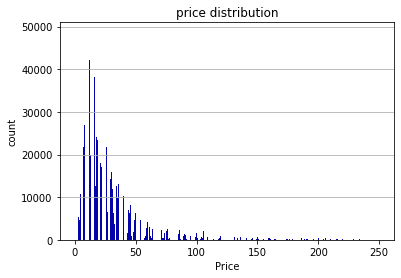

In [ ]:

#choosing a range of price for clearer visualization
n,  bins,  batches=plt.hist(x= train_data["price"], bins = "auto", color = '#0504aa',range=[0,250])
plt.grid(axis="y")
plt.xlabel("Price")
plt.ylabel("count")
plt.title("price distribution")

In [ ]:
train_data["price"].max()

2009.0

Clearly, price is right skewed>> take log(y)

# Feature Extraction

clearly,category_name is devided to:category,sub Category1,sub category2. Splitting them will help the model learn better.

In [ ]:
#train_data["category_name"][0].split("/")

In [ ]:
   
def   split_cat(text):
    try:
        return  text.split("/")
    except:
        return ("No label, No label, No label")

In [ ]:
train_data["general_cat"], train_data["subcat_1"],train_data["subcat_2"]=\
zip(*train_data["category_name"].apply(lambda  x: split_cat(x)))

In [ ]:
train_data.head()

,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,subcat_1,subcat_2
1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
6,Acacia pacific tides santorini top,3,Women/Swimwear/Two-Piece,Acacia Swimwear,64.0,0,Size small but straps slightly shortened to fi...,Women,Swimwear,Two-Piece
7,Girls cheer and tumbling bundle of 7,3,Sports & Outdoors/Apparel/Girls,Soffe,6.0,1,You get three pairs of Sophie cheer shorts siz...,Sports & Outdoors,Apparel,Girls
8,Girls Nike Pro shorts,3,Sports & Outdoors/Apparel/Girls,Nike,19.0,0,Girls Size small Plus green. Three shorts total.,Sports & Outdoors,Apparel,Girls


In [ ]:
train_data.isnull().sum()

name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
general_cat          0
subcat_1             0
subcat_2             0
dtype: int64

In [ ]:
train_data.drop("category_name", axis=1, inplace=True)

In [ ]:
# merged_data=train_data.append(test_data)

In [ ]:
# merged_data.drop(["train_id"],axis=1, inplace=True)
# merged_data.drop("test_id",axis=1, inplace=True)

In [ ]:
# merged_data

In [ ]:
# merged_data.info()

In [ ]:
# merged_data["category_name"].value_counts()

In [ ]:
# merged_data.describe()

Another quick way to get a feel of the type of data you are dealing with is to plot a histogram for each numerical attribute

# Discover and visualize the data to gain insights

So far you have only taken a quick glance at the data to get a general understanding of the kind of data you are manipulating. Now the goal is to go a little bit more in depth. First, make sure you have put the test set aside and you are only exploring the training set. Also, if the training set is very large, you may want to sample an exploration set, to make manipulations easy and fast. In our case, the set is quite small so you can just work directly on the full set. Let’s create a copy so you can play with it without harming the training set

## Visualizing which words has the highest frequencies within each category

### using the package **WordCloud**

This was one of the most exciting things that I learned during this competition! It was inspired from this amazing kernel: https://www.kaggle.com/thykhuely/mercari-interactive-eda-topic-modelling


In [ ]:
train_data["general_cat"]

1                Electronics
2                      Women
6                      Women
7          Sports & Outdoors
8          Sports & Outdoors
                 ...        
1482525                Women
1482528                Women
1482529                  Men
1482530                Women
1482531                 Kids
Name: general_cat, Length: 846453, dtype: object

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
def tokenize(text):
    """
    sent_tokenize(): segment text into sentences
    word_tokenize(): break sentences into words
    """
    try: 
        regex = re.compile('[' +re.escape(string.punctuation) + '0-9\\r\\t\\n]')
        text = regex.sub(" ", text) # remove punctuation
        
        tokens_ = [word_tokenize(s) for s in sent_tokenize(text)]
        tokens = []
        for token_by_sent in tokens_:
            tokens += token_by_sent
        tokens = list(filter(lambda t: t.lower() not in stop, tokens))
        filtered_tokens = [w for w in tokens if re.search('[a-zA-Z]', w)]
        filtered_tokens = [w.lower() for w in filtered_tokens if len(w)>=3]
        
        return filtered_tokens
            
    except TypeError as e: print(text,e)

In [ ]:
import re,string
from nltk.tokenize import sent_tokenize, word_tokenize
# build dictionary with key=category and values as all the descriptions related.
cat_desc = dict()
for cat in train_data["general_cat"]: 
    text = " ".join(train_data.loc[train_data['general_cat']==cat, 'item_description'].values)
    cat_desc[cat] = tokenize(text)


# find the most common words for the top 4 categories
women100 = Counter(cat_desc['Women']).most_common(100)
beauty100 = Counter(cat_desc['Beauty']).most_common(100)
kids100 = Counter(cat_desc['Kids']).most_common(100)
electronics100 = Counter(cat_desc['Electronics']).most_common(100)

In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


def generate_wordcloud(tup):
    wordcloud = WordCloud(background_color='white',
                          max_words=50, max_font_size=40,
                          random_state=42
                         ).generate(str(tup))
    return wordcloud

generate_wordcloud(women100)

# Prepare the data for Machine Learning algorithms

In [ ]:
train_data["item_condition_id"].value_counts()

1    303563
3    283419
2    235842
4     21938
5      1691
Name: item_condition_id, dtype: int64

In [ ]:
train_data["shipping"].value_counts()

0    517038
1    329415
Name: shipping, dtype: int64

In [ ]:
len(train_data["brand_name"].value_counts())


4789

brand name has 4791 unique values, 1-hot encoding it would bl

In [ ]:
len(train_data["name"].value_counts())


694736

In [ ]:
len(train_data["subcat_1"].value_counts())

104

In [ ]:
len(train_data["subcat_2"].value_counts())

669

# data encodinnng

1. name: Text>  BoW> countvectorizer

2. item_description; Text>  TF-IDF

3. general_cat; Text, categorical, not  ordinnal>>OHE

subcat_1:Text, categorical, not  ordinnal>>OHE

subcat_2:Text, categorical, not  ordinnal>>OHE
4. brand_name; categorical, not  ordinnal>>OHE
5. shipping; numerical, not  ordinnal>>  leave  as it is? (0's and 1's) >>   standard scaler

7. item_condition_id:   numeric(categorical nature), ordinnal?   >>   standard scaler

**encode**  variabbles    seperately thenconcat

In [ ]:
y=np.log1p(train_data["price"])

In [ ]:
train_data.head()

,name,item_condition_id,brand_name,price,shipping,item_description,general_cat,subcat_1,subcat_2
1,Razer BlackWidow Chroma Keyboard,3,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,AVA-VIV Blouse,1,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
6,Acacia pacific tides santorini top,3,Acacia Swimwear,64.0,0,Size small but straps slightly shortened to fi...,Women,Swimwear,Two-Piece
7,Girls cheer and tumbling bundle of 7,3,Soffe,6.0,1,You get three pairs of Sophie cheer shorts siz...,Sports & Outdoors,Apparel,Girls
8,Girls Nike Pro shorts,3,Nike,19.0,0,Girls Size small Plus green. Three shorts total.,Sports & Outdoors,Apparel,Girls


## 1.name column >BoW>>CountVectorizer

The name column consists of multiple words, so the simplest vectorization method to think of, in this case, is the BoW.

There are multiple methods to build a BoW model, including:

○ Binary: Put 1/0 if the word is present/absent in
a name/category.

○ Count: Put the number of times the word is
mentioned in a name/category.

○ Freq: Normalized counts by total words counts

○ TF-IDF: Normalize by the



The **name column** can be considered categorical, so I will try using both binary and count vectorizer and compare the results.

The **item_description column**, however, consists of sentences, which makes us think about giving larger values for words that repeat alot within the description, constrained by the repitions in the entire corpus. For example, a word like "great" should indicate higher prices, but a word like "the" shouldn't affect the price at all.
To make the model understand this, I'll use TF-IDF for that column.

In the following categorical columns: **general_category, subcat_1, subcat_2, brand_name**: each value is represented by 1-2 words and the number of unique values is limited, so using 1-hot encoding makes more sense than BoW.

*A question that might come to mind*: if the name column can be considered categorical, why not just use 1-hot encoding? 

the answer is: in OHE, each word is represented by a sparse array with a length=number of unique items in the column, which in this case equals 695132!! this will consume ALOT of memory!
On the contrary, in the BoW model, each row is represented by a length=number of words in that row.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfTransformer

The CountVectorizer provides a simple way to both tokenize a collection of text documents and build a vocabulary of known words
- punctuation is completely ignored and always treated as a token separator
- The matrix is (CSR) (Compressed Sparse Row), which is more compact representation for matrices with many zeros. The BoW is very sparse, it's a good way to represent it. You can easily recover the array when needed using toarray()


In [ ]:
train_data.head()

,name,item_condition_id,brand_name,price,shipping,item_description,general_cat,subcat_1,subcat_2
1,Razer BlackWidow Chroma Keyboard,3,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,AVA-VIV Blouse,1,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
6,Acacia pacific tides santorini top,3,Acacia Swimwear,64.0,0,Size small but straps slightly shortened to fi...,Women,Swimwear,Two-Piece
7,Girls cheer and tumbling bundle of 7,3,Soffe,6.0,1,You get three pairs of Sophie cheer shorts siz...,Sports & Outdoors,Apparel,Girls
8,Girls Nike Pro shorts,3,Nike,19.0,0,Girls Size small Plus green. Three shorts total.,Sports & Outdoors,Apparel,Girls


In [ ]:
train_data.shape

(846453, 9)

In [ ]:
bow_cv = CountVectorizer(stop_words=None)
x_name_cv = bow_cv.fit_transform(train_data["name"])

In [ ]:
x_name_cv.shape

(846453, 63763)

In [ ]:
# train_data["general_category"].nunique()

##2.item_description>>BoW>>TFIDF

I'll use the TFIDF because in the item_description, we want the words with the highest occurance in a sentence(constrained by highest occur. across all corpus, ignoring stop words)to contribute the most to the price prediction.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
bow_tf = TfidfVectorizer(stop_words="english", ngram_range=(1,1))

the  ngram_range parameter 

For  example,an ngram_range range =(1,2) applied to the following text
: "red sun, pink candy. Green flower."
will produce the  following output when calling get_feature_names():

['candy', 'candy green', 'green', 'green flower' , 'pink', 'pink candy', 'red', 'red sun', 'sun', 'sun pink']

The default  is(1,1) but if we consider only unigrams in the given data, then the single word cannot convey the details properly. 
For example, "size   small"  gives more info. than size,small separaetely.
But this increases the vocab size,so keep this trade-off in your mind.


In [ ]:
#bow_tf.get_stop_words()

In [ ]:

x_descr_tfidf = bow_tf.fit_transform(train_data["item_description"])

In [ ]:
x_descr_tfidf.shape

(846453, 102524)

In [ ]:
#x_descr_cv.shape

In [ ]:
# x_descr_cv.shape

## 3.brand_name, category_>>1-hot encoding

 The disadvantage of using sklearn's OneHotEncoder is that for high cardinality(multiple uniqe values), the feature space can really blow up quickly and you start fighting with the curse of dimensionality.This is why I'll use   LabelBinarizer.
explanation: in OneHotEncoder, each row is represented by a matrix with length = SUM of lengths of unique items of each feature.
You can find an example on the sklearn website: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html

***But  what is  a sparse matrix?***
the output is a SciPy sparse matrix, instead of a NumPy array(it's the default in OneHotEncoder, and with sparse_output=True in LabelBinarizer).  After onehot encoding we get a matrix with thousands of columns, and the matrix is full of
zeros except for one 1 per row. Using up tons of memory mostly to store zeros would
be very wasteful, **so instead a sparse matrix only stores the location of the nonzero
elements**. This is very
useful when you have categorical attributes with thousands of categories.

what does OHE return if the input is multiple columns?

In [ ]:
from sklearn.preprocessing import LabelBinarizer,  OneHotEncoder

In [ ]:
train_data.head()

,name,item_condition_id,brand_name,price,shipping,item_description,general_cat,subcat_1,subcat_2
1,Razer BlackWidow Chroma Keyboard,3,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,AVA-VIV Blouse,1,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
6,Acacia pacific tides santorini top,3,Acacia Swimwear,64.0,0,Size small but straps slightly shortened to fi...,Women,Swimwear,Two-Piece
7,Girls cheer and tumbling bundle of 7,3,Soffe,6.0,1,You get three pairs of Sophie cheer shorts siz...,Sports & Outdoors,Apparel,Girls
8,Girls Nike Pro shorts,3,Nike,19.0,0,Girls Size small Plus green. Three shorts total.,Sports & Outdoors,Apparel,Girls


###  inspecting the difference   between LabelBinarizer and OneHotEncoder:

In [ ]:
cat_1h =  OneHotEncoder()
cat_1h.fit_transform(train_data[["general_cat",  "subcat_1", "subcat_2"]])

<846453x783 sparse matrix of type '<class 'numpy.float64'>'
	with 2539359 stored elements in Compressed Sparse Row format>

In [ ]:
cat_1h =  LabelBinarizer(sparse_output=True)
cat_1h.fit_transform(train_data[["general_cat"]])

<846453x10 sparse matrix of type '<class 'numpy.int64'>'
	with 846453 stored elements in Compressed Sparse Row format>

In [ ]:

cat_1h =  LabelBinarizer(sparse_output=True)
cat_1h.fit_transform(train_data[["subcat_1"]])

<846453x104 sparse matrix of type '<class 'numpy.int64'>'
	with 846453 stored elements in Compressed Sparse Row format>

In [ ]:

cat_1h =  LabelBinarizer(sparse_output=True)
cat_1h.fit_transform(train_data[["subcat_2"]])

<846453x669 sparse matrix of type '<class 'numpy.int64'>'
	with 846453 stored elements in Compressed Sparse Row format>

As we can see, LabelBinarizer   stores the result  as innt64, while OneHotEncoder  stores it  as  float64.>> **using  LabelBinarizer  to save  memory**

### brand_name

In [ ]:
lbl = LabelBinarizer(sparse_output=True)
#True if the returned array from transform is desired to be in sparse CSR format
x_brand_lb=lbl.fit_transform(train_data["brand_name"])

In [ ]:
x_brand_lb.shape

(846453, 4789)

### general_category

In [ ]:
lbl = LabelBinarizer(sparse_output=True)
#True if the returned array from transform is desired to be in sparse CSR format
x_general_cat_lb=lbl.fit_transform(train_data["general_cat"])

In [ ]:
x_general_cat_lb.shape

(846453, 10)

### subcat_1

In [ ]:
lbl = LabelBinarizer(sparse_output=True)
#True if the returned array from transform is desired to be in sparse CSR format
x_subcat_1_lb=lbl.fit_transform(train_data["subcat_1"])

In [ ]:
x_subcat_1_lb.shape

(846453, 104)

### subcat_2

In [ ]:
lbl = LabelBinarizer(sparse_output=True)
#True if the returned array from transform is desired to be in sparse CSR format
x_subcat_2_lb=lbl.fit_transform(train_data["subcat_2"])

In [ ]:
x_subcat_2_lb.shape

(846453, 669)

##  4. item_condition_id  and shipping

shipping is a binary,categorical variable, while item_condition_id is an ordinal, numerical variable. 
we can use StandardScaler with item_condition_id, while
shipping should be 1 hot encoded since its also a categorical variable(1 here means "shipped" and 0 means " not shipped")

In [ ]:

train_data["shipping"] = train_data["shipping"].astype("category")

In [ ]:
lbl = LabelBinarizer(sparse_output=True)
#True if the returned array from transform is desired to be in sparse CSR format
x_shipping_lb=lbl.fit_transform(train_data["shipping"])

In [ ]:
x_shipping_lb.shape

(846453, 1)

In [ ]:
x_shipping_lb[0]

<1x1 sparse matrix of type '<class 'numpy.int64'>'
	with 0 stored elements in Compressed Sparse Row format>

In [ ]:
train_data["item_condition_id"].values

array([3, 1, 3, ..., 2, 2, 2])

In [ ]:
 from sklearn.preprocessing import StandardScaler
 scaler = StandardScaler()
 x_item_condition_id_lb=scaler.fit_transform(train_data["item_condition_id"].values.reshape(-1, 1))

In [ ]:
# x_item_condition_id_lb_t = x_item_condition_id_lb.transpose()

In [ ]:
x_item_condition_id_lb.shape

(846453, 1)

## Putting it all together

In [ ]:
from scipy.sparse import csr_matrix, hstack

https://www.kaggle.com/tunguz/more-effective-ridge-lgbm-script-lb-0-44823

In [ ]:
train_data.info()

In [ ]:
x=hstack(( x_item_condition_id_lb,
          x_shipping_lb,
          x_general_cat_lb,
          x_subcat_1_lb,
          x_subcat_2_lb,
          x_brand_lb,
          x_descr_tfidf,
          x_name_cv
)).tocsr()

In [ ]:
x.shape

(846453, 171861)

# Model

## Ridge regression

Ridge Regression
Ridge Regression (also called Tikhonov regularization) is a regularized version of Lin‐
ear Regression: a regularization term 
 is added to the cost function. 
This forces the learning algorithm to not only fit the data but also keep the model
weights as small as possible. Note that the regularization term should only be added
to the cost function during training. Once the model is trained, you want to evaluate
the model’s performance using the unregularized performance measure.

**It is important to scale the data (e.g., using a StandardScaler) 
before performing Ridge Regression, as it is sensitive to the scale of
the input features. This is true of most regularized models.**

 The main advantage of Ridge Regression is its speed (~ 10 minutes). One notable observation is that Ridge was a lot faster than LASSO since L2 loss is much easier to optimize compared with L1 loss.



In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.2)

In [ ]:

from sklearn.linear_model import Ridge
from sklearn import metrics

In [ ]:
ridge = Ridge(solver = "lsqr", fit_intercept=False)
#solver = "lsqr" uses the dedicated regularized least-squares routine scipy.sparse.linalg.lsqr. It is the fastest and uses an iterative procedure.

In [ ]:
ridge.fit(x_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=False, max_iter=None,
      normalize=False, random_state=None, solver='lsqr', tol=0.001)

12 seconds

In [ ]:
y_pred_ridge = ridge.predict(x_val)

In [ ]:

print('Mean Squared Error:', metrics.mean_squared_error(y_val, y_pred_ridge))

Mean Squared Error: 0.20182403053028722



## Define RMSLE Error Function

This is for checking the predictions. Note that the Y and Y_pred will already be in log scale by the time this is used, so no need to log them in the function.




In [ ]:
def rmsle(Y, Y_pred):
    assert Y.shape == Y_pred.shape
    return np.sqrt(np.mean(np.square(Y_pred - Y )))

In [ ]:
print("RMSLE Error:", rmsle(y_val, y_pred_ridge))

RMSLE Error: 0.4492482949664765


# Future   work

-The accuracy could increase by changing the ngram in the TF-IDF to (1,3).


-I think intercations between brand and category feature interaction is key in this competition, for example the price of "nike" shoes are very different than the ones for a "nike" tshirt. Without interaction terms that can only be captured if the difference between shirt and shoe remains the same for all brands, but this is probably not the case, e.g. the price difference is probably smaller for a cheaper brand. 


In addition, the 1st place in this competition used MLP.
A great blog that discusses this in more details:
https://sijunhe.github.io/blog/2018/03/02/kaggle-mercari-price-suggestion-challenge/

# Resources

- https://www.kaggle.com/apapiu/ridge-script

- 08_end_to_end_machine_learning_project.ipynb
from Hands On Machine Learning Book.

- https://www.kaggle.com/thykhuely/mercari-interactive-eda-topic-modelling